Assignment details:
- Okay to throw out 1 or so messages
- TFIDF
- Minimal cleanup (parser takes everything to lowercase, take out \n, stick with the defaults)
- Don't worry about stop words
- Turn data into vectors
- Cluster the vectors
- Into NB, word content and the cluster one-hot-encoded
- Binary classification
- Accuracy, precision, recall
- Class report
- Confusion matrix
- Should get ~95% accuracy

## Import Required Libraries and Set Global Seed

In [1]:
import os
import email  # for parsing emails
import numpy as np
import pandas as pd
import re
from collections import Counter
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize, KBinsDiscretizer, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

SEED = 13

## Extract Text from Emails and Labels from Folder Names

In [2]:
# Get all "ham" and "spam" file paths
paths = []  # list of full file paths

for root, dirs, files in os.walk("./SpamAssassinMessages"):
    for file in files:
        if file.startswith('.'):
            continue  # skip hidden files like .DS_Store

        abs_path = os.path.join(root, file)
        if "ham" in abs_path or "spam" in abs_path:
            paths.append(abs_path)
        else:
            print(f"Skipping unknown type: {abs_path}")

In [3]:
# Make sure all the file paths are in the list
len(paths)

9353

In [4]:
paths[:5]

['./SpamAssassinMessages/spam/00249.5f45607c1bffe89f60ba1ec9f878039a',
 './SpamAssassinMessages/spam/0355.94ebf637e4bd3db8a81c8ce68ecf681d',
 './SpamAssassinMessages/spam/0395.bb934e8b4c39d5eab38f828a26f760b4',
 './SpamAssassinMessages/spam/0485.9021367278833179285091e5201f5854',
 './SpamAssassinMessages/spam/00373.ebe8670ac56b04125c25100a36ab0510']

In [5]:
# Prepare output containers
targets = []       # 0 = ham, 1 = spam
files = []         # just the filenames
msg_texts = []     # extracted text content
content_types = [] # for debugging
types = Counter()  # count of content types

# Process each email
for path in paths:
    try:
        with open(path, "r", encoding="latin-1") as f:
            msg = email.message_from_file(f)  # Parse the raw file into a Message object

        content_type = msg.get_content_type()
        payload = msg.get_payload()
        text = None  # Placeholder for extracted content

        # If it's multipart (i.e. contains multiple parts like text, html, or embedded emails)
        if msg.is_multipart():
        # if msg.startswith("multipart"):
            for part in payload:
                # Case 1: part is plain text
                if part.get_content_type().endswith("plain"):
                    text = part.get_payload()
                    break  # Found text, done

                # Case 2: part is HTML
                elif part.get_content_type().endswith("html"):
                    html = part.get_payload()
                    soup = BeautifulSoup(html, "html.parser")
                    text = soup.get_text()
                    break  # Found usable text, done

                # Case 3: part is itself a multipart email (i.e. embedded message or alternative)
                elif part.is_multipart():
                # elif msg.startswith("multipart"):
                    for subpart in part.get_payload():  # get payload for part (of original payload) first, then can work with subpart
                        if subpart.get_content_type().endswith("plain"):
                            text = subpart.get_payload()
                            break
                        elif subpart.get_content_type().endswith("html"):
                            html = subpart.get_payload()
                            soup = BeautifulSoup(html, "html.parser")
                            text = soup.get_text()
                            break
                    if text: break  # Stop outer loop if we got text

                # Optional: debug unknown part types
                else:
                    print(f"{path}: unhandled multipart part type: {part.get_content_type()}")

        # If it's a single-part message
        elif content_type.endswith("plain"):
            text = payload

        elif content_type.endswith("html"):
            soup = BeautifulSoup(payload, "html.parser")
            text = soup.get_text()

        # Save the results
        if "ham" in path:
            targets.append(0)
        elif "spam" in path:
            targets.append(1)

        file = os.path.basename(path)
        files.append(file)
        msg_texts.append(text if text else "[no usable text]")
        content_types.append(content_type)  # of whole message (not part)
        types[content_type] += 1

    except Exception as e:
        print(f"Failed to process {path}: {e}")

In [6]:
types

Counter({'text/plain': 7413,
         'text/html': 1193,
         'multipart/alternative': 326,
         'multipart/signed': 180,
         'multipart/mixed': 179,
         'multipart/related': 56,
         'multipart/report': 5,
         'text/plain charset=us-ascii': 1})

In [7]:
len(files), len(msg_texts), len(targets)

(9353, 9353, 9353)

In [8]:
files[:5]

['00249.5f45607c1bffe89f60ba1ec9f878039a',
 '0355.94ebf637e4bd3db8a81c8ce68ecf681d',
 '0395.bb934e8b4c39d5eab38f828a26f760b4',
 '0485.9021367278833179285091e5201f5854',
 '00373.ebe8670ac56b04125c25100a36ab0510']

In [9]:
msg_texts[:3]

['Dear Homeowner,\n \nInterest Rates are at their lowest point in 40 years!\n\nWe help you find the best rate for your situation by\nmatching your needs with hundreds of lenders!\n\nHome Improvement, Refinance, Second Mortgage,\nHome Equity Loans, and More! Even with less than\nperfect credit!\n\nThis service is 100% FREE to home owners and new\nhome buyers without any obligation. \n\nJust fill out a quick, simple form and jump-start\nyour future plans today!\n\n\nVisit http://61.145.116.186/user0201/index.asp?Afft=QM10\n\n\n\n\n\n\nTo unsubscribe, please visit:\n\nhttp://61.145.116.186/light/watch.asp\n\n\n',
 "Friend,Now you can copy DVD's and Games\nhttp://www.terra.es/personal9/iop1008/\n\nBACKUP DVD VIDEO's WITH YOUR CD-R BURNER\n\nWith 321 studio's software, you can now copy\nany DVD and Playstation Game.  Never buy another \nbackup DVD movie again.  Just copy it!\n\nThis is the first time this software is being made\navailable to the public. All the software you need \nto burn y

In [10]:
print(targets.count(1), targets.count(0))
print(targets.count(1) + targets.count(0))

2399 6954
9353


In [11]:
msg_texts.count("[no usable text]")

4

In [12]:
data = pd.DataFrame({"Msg": files, "Target": targets, "Text": msg_texts, "Type": content_types})
data

,Msg,Target,Text,Type
0,00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n \nInterest Rates are at thei...",text/plain
1,0355.94ebf637e4bd3db8a81c8ce68ecf681d,1,"Friend,Now you can copy DVD's and Games\nhttp:...",multipart/alternative
2,0395.bb934e8b4c39d5eab38f828a26f760b4,1,Pocket the newest 8 year annuity!\t Pocket th...,multipart/alternative
3,0485.9021367278833179285091e5201f5854,1,\nCongratulations! You Get a Free Handheld Org...,text/html
4,00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...,text/plain
...,...,...,...,...
9348,00609.dd49926ce94a1ea328cce9b62825bc97,0,"I'm one of the 30,000 but it's not working ver...",text/plain
9349,00957.e0b56b117f3ec5f85e432a9d2a47801f,0,Damien Morton quoted:\n>W3C approves HTML 4 'e...,text/plain
9350,01127.841233b48eceb74a825417d8d918abf8,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n> t...",text/plain
9351,01178.5c977dff972cd6eef64d4173b90307f0,0,"Once upon a time, Manfred wrote :\n\n> I would...",text/plain


In [13]:
data[data["Text"] == "[no usable text]"]

,Msg,Target,Text,Type
460,00467.5b733c506b7165424a0d4a298e67970f,1,[no usable text],multipart/alternative
793,0478.16f274ffd3e884a574c9461012cadea6,1,[no usable text],multipart/alternative
1524,00204.4cf15f97b8ea08bfafab7d5091b8fbe7,1,[no usable text],text/plain charset=us-ascii
2543,01214.973b4598b630a989967ff69b19f95d4a,1,[no usable text],multipart/alternative


In [14]:
# bad_file = "00467.5b733c506b7165424a0d4a298e67970f"
# for path in paths:
#     if bad_file in path:
#         with open(path, "r", encoding="latin-1") as f:
#             bad_file = email.message_from_file(f)
#         content = bad_file.get_payload()
#         print(content)

In [15]:
# bad_file.get_content_type()

I tried to debug the multipart messages but wasn't able to do it easily. They are multi-part and the part is coded as plain/text but contains html. I tried to treat it as such but what I did, didn't work.

In [16]:
data_clean = data[data["Text"] != "[no usable text]"].drop(columns=['Type'])
data_clean.shape

(9349, 3)

In [17]:
data_clean.head(10)

,Msg,Target,Text
0,00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n \nInterest Rates are at thei..."
1,0355.94ebf637e4bd3db8a81c8ce68ecf681d,1,"Friend,Now you can copy DVD's and Games\nhttp:..."
2,0395.bb934e8b4c39d5eab38f828a26f760b4,1,Pocket the newest 8 year annuity!\t Pocket th...
3,0485.9021367278833179285091e5201f5854,1,\nCongratulations! You Get a Free Handheld Org...
4,00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...
5,0343.0630afbe4ee1ffd0db0ffb81c6de98de,1,\n\nCONSANTLY being\nbombarded by so-called F...
6,00214.1367039e50dc6b7adb0f2aa8aba83216,1,We dare you...\n Try to find a better annuity...
7,0125.44381546181fc6c5d7ea59e917f232c5,1,YOUR SEX DRIVE SHOULD NEVER BE SECOND ON THE L...
8,00210.050ffd105bd4e006771ee63cabc59978,1,IMPORTANT INFORMATION:\n\nThe new domain names...
9,0108.4506c2ef846b80b9a7beb90315b22701,1,\n\nDigital Publishing Tools - Free Software A...


## Do Some Simple Cleaning

In [18]:
# Some basic cleaning
def clean_text(text):
    
    # [] — Character class: matches any one character inside the brackets
    # Replace control characters: newline (\n), tab (\t), and carriage return (\r) with a space
    text = re.sub(r'[\n\t\r]', ' ', text)

    # [^] — Negated character class: matches any one character that is not inside the brackets
    # Remove all characters *except* word characters (\w) and whitespace (\s)
    # Removes punctuation and special symbols except apostrophes for contractions, keeping only letters, digits, underscores, and spaces
    text = re.sub(r"[^\w\s']", ' ', text)
    
    # Replace multiple consecutive whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading and trailing whitespace
    return text.strip()

# Apply cleaning function to the "Text" column
data_clean["Clean_Text"] = data_clean["Text"].apply(clean_text)

data_clean.head(10)

,Msg,Target,Text,Clean_Text
0,00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n \nInterest Rates are at thei...",Dear Homeowner Interest Rates are at their low...
1,0355.94ebf637e4bd3db8a81c8ce68ecf681d,1,"Friend,Now you can copy DVD's and Games\nhttp:...",Friend Now you can copy DVD's and Games http w...
2,0395.bb934e8b4c39d5eab38f828a26f760b4,1,Pocket the newest 8 year annuity!\t Pocket th...,Pocket the newest 8 year annuity Pocket the ne...
3,0485.9021367278833179285091e5201f5854,1,\nCongratulations! You Get a Free Handheld Org...,Congratulations You Get a Free Handheld Organi...
4,00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...,ATTENTION This is a MUST for ALL Computer User...
5,0343.0630afbe4ee1ffd0db0ffb81c6de98de,1,\n\nCONSANTLY being\nbombarded by so-called F...,CONSANTLY being bombarded by so called FREE mo...
6,00214.1367039e50dc6b7adb0f2aa8aba83216,1,We dare you...\n Try to find a better annuity...,We dare you Try to find a better annuity 20 5 ...
7,0125.44381546181fc6c5d7ea59e917f232c5,1,YOUR SEX DRIVE SHOULD NEVER BE SECOND ON THE L...,YOUR SEX DRIVE SHOULD NEVER BE SECOND ON THE L...
8,00210.050ffd105bd4e006771ee63cabc59978,1,IMPORTANT INFORMATION:\n\nThe new domain names...,IMPORTANT INFORMATION The new domain names are...
9,0108.4506c2ef846b80b9a7beb90315b22701,1,\n\nDigital Publishing Tools - Free Software A...,Digital Publishing Tools Free Software Alert P...


## Create Bag-of-Words Representation: Vector of Word Counts for Each Message

In [19]:
# Use CountVectorizer to fit_transform all the data
# CountVectorizer lowercases text and tokenizes using the default regex \b\w\w+\b:
# it extracts words made of 2 or more alphanumeric characters (letters, digits, underscore),
# ignoring punctuation and splitting at word boundaries (like spaces or symbols).

vectorizer = CountVectorizer()
sparse_mat = vectorizer.fit_transform(data_clean["Clean_Text"])
print(type(sparse_mat))                                

<class 'scipy.sparse._csr.csr_matrix'>


In [20]:
print(list(vectorizer.vocabulary_)[:10])
print(list(vectorizer.vocabulary_.keys())[:10])
print(len(vectorizer.vocabulary_))

['dear', 'homeowner', 'interest', 'rates', 'are', 'at', 'their', 'lowest', 'point', 'in']
['dear', 'homeowner', 'interest', 'rates', 'are', 'at', 'their', 'lowest', 'point', 'in']
88901


In [21]:
# Convert to sparse matrix to dense numpy array
dense_array = sparse_mat.toarray()

# Convert to DataFrame with feature names
count_vectors = pd.DataFrame(dense_array, columns=vectorizer.get_feature_names_out())
print(count_vectors['dear'])
print(count_vectors.shape) # number of messages, length of vocab

0       1
1       0
2       0
3       1
4       0
       ..
9344    0
9345    0
9346    0
9347    0
9348    0
Name: dear, Length: 9349, dtype: int64
(9349, 88901)


## Perform Clustering on Bag-of-Words

### K-Means with Euclidean Distance
#### Make an Elbow Plot to Find K

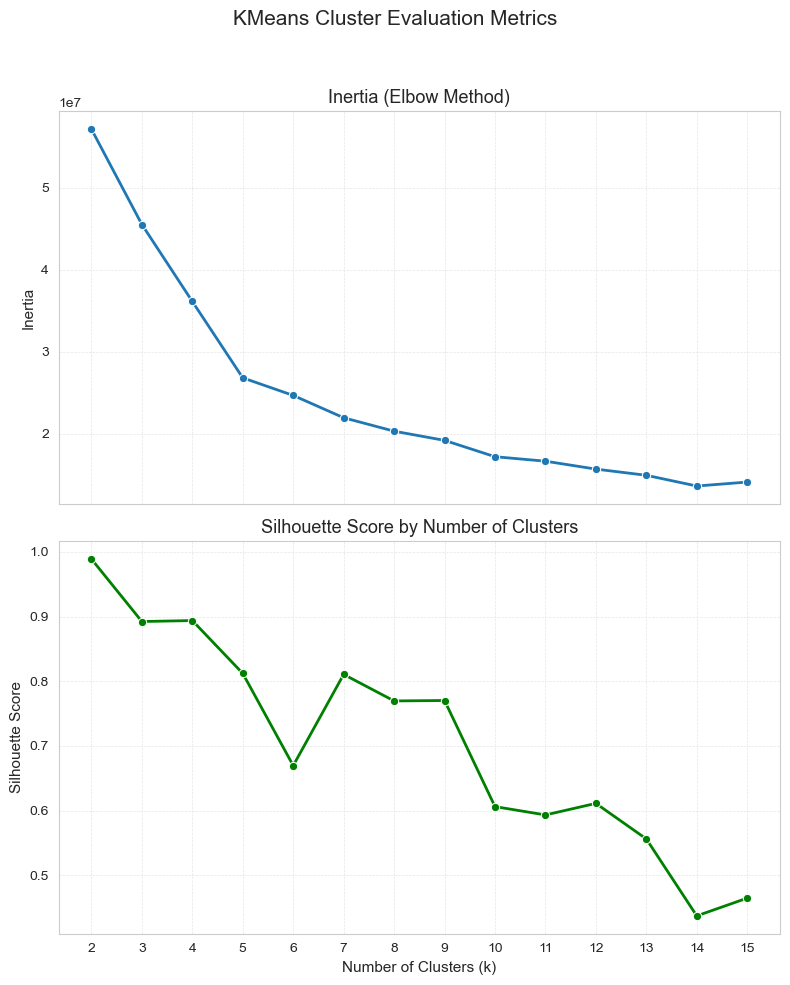

In [22]:
# Range of cluster counts to try
k_values = range(2, 16)  # silhouette score not defined for k=1

inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(
        init='k-means++',
        n_clusters=k,
        n_init=3,
        random_state=SEED
    )
    labels = kmeans.fit_predict(count_vectors)
    inertias.append(kmeans.inertia_)  # inertia = sum of squared distances to cluster centers
    sil_score = silhouette_score(count_vectors, labels)
    silhouette_scores.append(sil_score)

# Set a cleaner seaborn style with lighter grid
sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.9'})

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot Inertia (Elbow)
sns.lineplot(x=k_values, y=inertias, marker='o', linewidth=2, ax=axes[0])
axes[0].set_title('Inertia (Elbow Method)', fontsize=13)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].grid(True, linestyle='--', linewidth=0.5)

# Plot Silhouette Score
sns.lineplot(x=k_values, y=silhouette_scores, marker='o', linewidth=2, color='green', ax=axes[1])
axes[1].set_title('Silhouette Score by Number of Clusters', fontsize=13)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].grid(True, linestyle='--', linewidth=0.5)

# Improve layout for report use
plt.suptitle('KMeans Cluster Evaluation Metrics', fontsize=15)
plt.xticks(k_values)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves room for the suptitle
plt.show()

#### Get KMean Clusters with Tuned K

In [23]:
# Get KMean Clusters with Tuned K
optimal_k = 9
kmeans = KMeans(
    init='k-means++',
    n_clusters=optimal_k,
    n_init=10,
    random_state=SEED
)
cluster_labels = kmeans.fit_predict(count_vectors)
data_clean["KMeans_Cluster"] = cluster_labels
data_clean.head()

,Msg,Target,Text,Clean_Text,KMeans_Cluster
0,00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n \nInterest Rates are at thei...",Dear Homeowner Interest Rates are at their low...,0
1,0355.94ebf637e4bd3db8a81c8ce68ecf681d,1,"Friend,Now you can copy DVD's and Games\nhttp:...",Friend Now you can copy DVD's and Games http w...,0
2,0395.bb934e8b4c39d5eab38f828a26f760b4,1,Pocket the newest 8 year annuity!\t Pocket th...,Pocket the newest 8 year annuity Pocket the ne...,0
3,0485.9021367278833179285091e5201f5854,1,\nCongratulations! You Get a Free Handheld Org...,Congratulations You Get a Free Handheld Organi...,0
4,00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...,ATTENTION This is a MUST for ALL Computer User...,0


In [24]:
print(data_clean["KMeans_Cluster"].value_counts())

KMeans_Cluster
0    8497
8     705
6     122
2      10
4       8
3       3
1       2
7       1
5       1
Name: count, dtype: int64


#### Try Mini-Batch K-Means with L2 Normalization

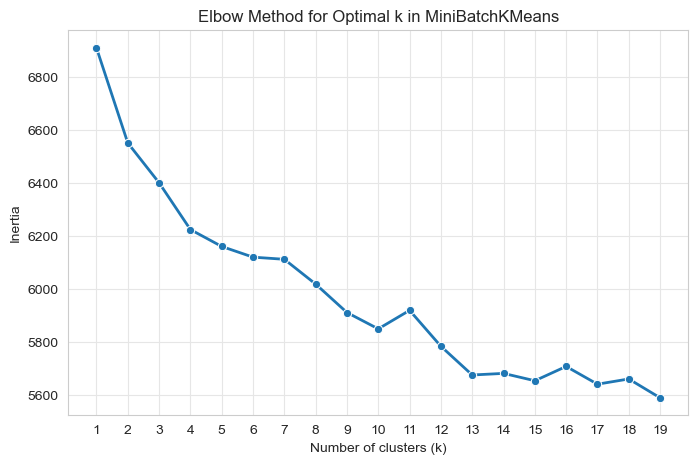

In [25]:
# Experimenting a bit
# Normalize to approximate cosine similarity (optional but common)
count_vectors_norm = normalize(count_vectors, norm='l2')

# Range of cluster counts to try
k_values = range(1, 20)

# Store the inertia for each k
inertias = []

for k in k_values:
    kmeans = MiniBatchKMeans(
        init='k-means++',
        batch_size=1000,
        n_clusters=k,
        n_init=10,
        random_state=SEED
    )
    kmeans.fit(count_vectors_norm)
    inertias.append(kmeans.inertia_)  # inertia = sum of squared distances to cluster centers

# Plot the elbow curve
sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.9'})
plt.figure(figsize=(8, 5))
sns.lineplot(x=k_values, y=inertias, marker='o', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k in MiniBatchKMeans')
plt.xticks(k_values)
plt.show()

### K-Means with L2 Normalized Vector Inputs

#### Apply L2 Normalization

Since K-Means doesn't directly support cosine similarity as a distance metric. Using L2 normalization preserves the vector direction but makes the length of each document vector equal to 1. If two vectors are L2-normalized, their dot product equals the cosine similarity. Normalizing also helps reduce bias from document length.

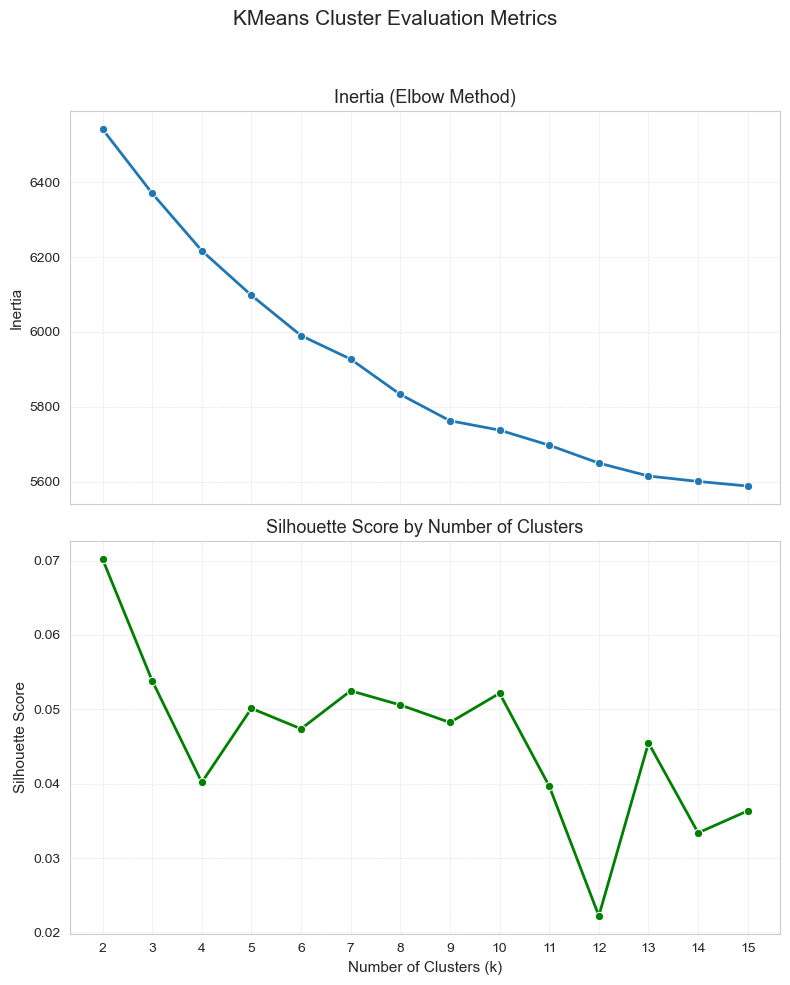

In [26]:
# Normalize to approximate cosine similarity (optional but common)
count_vectors_norm = normalize(count_vectors, norm='l2')

# Range of cluster counts to try
k_values = range(2, 16)  # silhouette score not defined for k=1

inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(
        init='k-means++',
        n_clusters=k,
        n_init=3,
        random_state=SEED
    )
    labels = kmeans.fit_predict(count_vectors_norm)
    inertias.append(kmeans.inertia_)  # inertia = sum of squared distances to cluster centers
    sil_score = silhouette_score(count_vectors_norm, labels)
    silhouette_scores.append(sil_score)

# Set a cleaner seaborn style with lighter grid
sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.9'})

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot Inertia (Elbow)
sns.lineplot(x=k_values, y=inertias, marker='o', linewidth=2, ax=axes[0])
axes[0].set_title('Inertia (Elbow Method)', fontsize=13)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].grid(True, linestyle='--', linewidth=0.5)

# Plot Silhouette Score
sns.lineplot(x=k_values, y=silhouette_scores, marker='o', linewidth=2, color='green', ax=axes[1])
axes[1].set_title('Silhouette Score by Number of Clusters', fontsize=13)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].grid(True, linestyle='--', linewidth=0.5)

# Improve layout for report use
plt.suptitle('KMeans Cluster Evaluation Metrics', fontsize=15)
plt.xticks(k_values)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves room for the suptitle
plt.show()

In [27]:
# Get KMean Clusters with Tuned K and L2 Normalized Vectors
optimal_k = 10
kmeans = KMeans(
    init='k-means++',
    n_clusters=optimal_k,
    n_init=10,
    random_state=SEED
)
cluster_labels = kmeans.fit_predict(count_vectors_norm)
data_clean["KMeans_Cluster_Norm"] = cluster_labels
data_clean.head()

,Msg,Target,Text,Clean_Text,KMeans_Cluster,KMeans_Cluster_Norm
0,00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n \nInterest Rates are at thei...",Dear Homeowner Interest Rates are at their low...,0,7
1,0355.94ebf637e4bd3db8a81c8ce68ecf681d,1,"Friend,Now you can copy DVD's and Games\nhttp:...",Friend Now you can copy DVD's and Games http w...,0,6
2,0395.bb934e8b4c39d5eab38f828a26f760b4,1,Pocket the newest 8 year annuity!\t Pocket th...,Pocket the newest 8 year annuity Pocket the ne...,0,1
3,0485.9021367278833179285091e5201f5854,1,\nCongratulations! You Get a Free Handheld Org...,Congratulations You Get a Free Handheld Organi...,0,6
4,00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...,ATTENTION This is a MUST for ALL Computer User...,0,7


In [28]:
print(data_clean["KMeans_Cluster_Norm"].value_counts())

KMeans_Cluster_Norm
0    2735
6    1212
3    1200
1    1030
9     801
5     664
4     617
2     575
7     384
8     131
Name: count, dtype: int64


### DBSCAN Clustering

#### Make a k-Distance Plot to Approximate the Best Distance (eps)

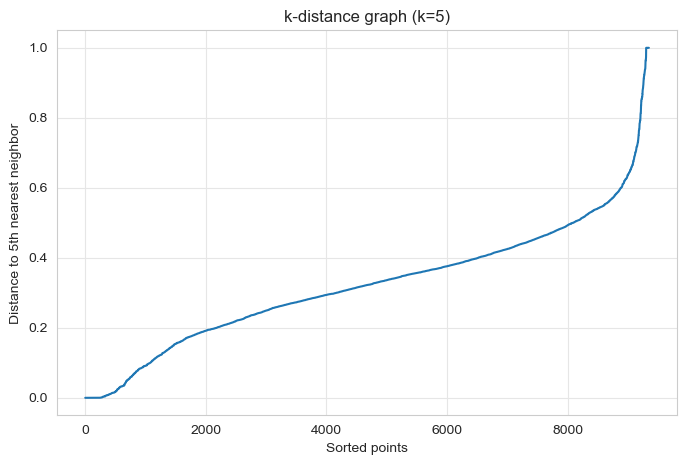

In [29]:
# k-distance plot to find optimal eps for DBSCAN
neigh = NearestNeighbors(n_neighbors=5, metric="cosine")
nbrs = neigh.fit(count_vectors)
distances, _ = nbrs.kneighbors(count_vectors)
k_distances = np.sort(distances[:, 4])  # 4 = k-1

sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.9'})
plt.figure(figsize=(8, 5))
sns.lineplot(k_distances)
plt.title("k-distance graph (k=5)")
plt.ylabel("Distance to 5th nearest neighbor")
plt.xlabel("Sorted points")
plt.show()

#### Tune eps and min_samples

In [30]:
# Tune eps and min_samples
# eps controls the size of a neighborhood, min_samples controls the density requirement
eps_values = np.arange(0.4, 1, 0.1)
min_samples_values = [3, 5, 7, 10, 15]
results = []

n_total = count_vectors.shape[0] # for calculating noise ratio

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = db.fit_predict(count_vectors)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        noise_ratio = n_noise / n_total

        label_counts = Counter(labels)
        cluster_sizes = [count for label, count in label_counts.items() if label != -1]
        n_clusters_over_10 = sum(1 for size in cluster_sizes if size > 10)

        # Penalize or skip configs with too much noise or not enough clusters
        if n_clusters <= 1 or noise_ratio >= 0.10:
            score = -1  # or np.nan if you want to filter later, invalid silhouette
        else:
            score = silhouette_score(count_vectors, labels, metric='cosine')

        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_clusters_>10": n_clusters_over_10,
            "n_noise": n_noise,
            "noise_ratio": round(noise_ratio, 3),
            "silhouette": score
        })

# Display results sorted by silhouette
pd.set_option('display.max_rows', None)
df = pd.DataFrame(results)
df.sort_values(by='silhouette', ascending=False, inplace=True)
print(df)


    eps  min_samples  n_clusters  n_clusters_>10  n_noise  noise_ratio  \
27  0.9            7           4               2       96        0.010   
26  0.9            5           6               1       79        0.008   
28  0.9           10           3               2      105        0.011   
29  0.9           15           2               2      124        0.013   
21  0.8            5           6               1      138        0.015   
23  0.8           10           2               1      160        0.017   
22  0.8            7           2               1      160        0.017   
25  0.9            3          12               1       54        0.006   
16  0.7            5           7               1      187        0.020   
20  0.8            3          14               1      107        0.011   
15  0.7            3          19               1      142        0.015   
11  0.6            5          11               1      381        0.041   
10  0.6            3          36      

#### Get Cluster Labels with the Best Hyperparameters

In [31]:
# Apply the best eps and min_samples
db = DBSCAN(eps=0.9, min_samples=7, metric='cosine') # eps = distance b/t points to be considered a cluster
cluster_labels = db.fit_predict(count_vectors)
data_clean["DBSCAN_Cluster"] = cluster_labels
data_clean.head()

,Msg,Target,Text,Clean_Text,KMeans_Cluster,KMeans_Cluster_Norm,DBSCAN_Cluster
0,00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n \nInterest Rates are at thei...",Dear Homeowner Interest Rates are at their low...,0,7,0
1,0355.94ebf637e4bd3db8a81c8ce68ecf681d,1,"Friend,Now you can copy DVD's and Games\nhttp:...",Friend Now you can copy DVD's and Games http w...,0,6,0
2,0395.bb934e8b4c39d5eab38f828a26f760b4,1,Pocket the newest 8 year annuity!\t Pocket th...,Pocket the newest 8 year annuity Pocket the ne...,0,1,0
3,0485.9021367278833179285091e5201f5854,1,\nCongratulations! You Get a Free Handheld Org...,Congratulations You Get a Free Handheld Organi...,0,6,0
4,00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...,ATTENTION This is a MUST for ALL Computer User...,0,7,0


In [32]:
print(data_clean["DBSCAN_Cluster"].value_counts())

DBSCAN_Cluster
 0    9207
-1      96
 1      28
 3      10
 2       8
Name: count, dtype: int64


## Get a TF-IDF Vector for Each Message

In [33]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_sparse_mat = tfidf_vectorizer.fit_transform(data_clean["Clean_Text"]) # fit on the full dataset
tfidf_array = tfidf_sparse_mat.toarray()

In [34]:
tfidf_df = pd.DataFrame(tfidf_array, columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df['dear'][:10])
print(tfidf_df.shape) # number of messages, length of vocab

0    0.086932
1    0.000000
2    0.000000
3    0.058625
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: dear, dtype: float64
(9349, 88901)


### Make DataFrames with TF-IDF Vectors and Cluster Labels for Each Clustering Method 

In [35]:
# Align indexes before concatenation
# Reset indexes to guarantee row-wise alignment
tfidf_df = tfidf_df.reset_index(drop=True)
kmeans_cluster = data_clean["KMeans_Cluster"].reset_index(drop=True)
kmeans_l2_cluster = data_clean["KMeans_Cluster_Norm"].reset_index(drop=True)
dbscan_cluster = data_clean["DBSCAN_Cluster"].reset_index(drop=True)
# Map each DBSCAN cluster to 1+ cluster identity to avoid negative numbers in NB
dbscan_cluster_adjusted = dbscan_cluster + 1

# Now safely concatenate
tfidf_kmeans = pd.concat([tfidf_df, kmeans_cluster], axis=1)
tfidf_kmeans_l2 = pd.concat([tfidf_df, kmeans_l2_cluster], axis=1)
tfidf_dbscan = pd.concat([tfidf_df, dbscan_cluster_adjusted], axis=1)

print(tfidf_df.shape, tfidf_kmeans.shape, tfidf_kmeans_l2.shape, tfidf_dbscan.shape)

(9349, 88901) (9349, 88902) (9349, 88902) (9349, 88902)


In [36]:
print(tfidf_kmeans[["dear", "homeowner", "KMeans_Cluster"]].iloc[:5])
print(tfidf_kmeans_l2[["dear", "homeowner", "KMeans_Cluster_Norm"]].iloc[:5])
print(tfidf_dbscan[["dear", "homeowner", "DBSCAN_Cluster"]].iloc[:5])

       dear  homeowner  KMeans_Cluster
0  0.086932   0.131632               0
1  0.000000   0.000000               0
2  0.000000   0.000000               0
3  0.058625   0.000000               0
4  0.000000   0.000000               0
       dear  homeowner  KMeans_Cluster_Norm
0  0.086932   0.131632                    7
1  0.000000   0.000000                    6
2  0.000000   0.000000                    1
3  0.058625   0.000000                    6
4  0.000000   0.000000                    7
       dear  homeowner  DBSCAN_Cluster
0  0.086932   0.131632               1
1  0.000000   0.000000               1
2  0.000000   0.000000               1
3  0.058625   0.000000               1
4  0.000000   0.000000               1


In [37]:
print(tfidf_kmeans["KMeans_Cluster"].value_counts())
print(tfidf_kmeans_l2["KMeans_Cluster_Norm"].value_counts())
print(tfidf_dbscan["DBSCAN_Cluster"].value_counts())

KMeans_Cluster
0    8497
8     705
6     122
2      10
4       8
3       3
1       2
7       1
5       1
Name: count, dtype: int64
KMeans_Cluster_Norm
0    2735
6    1212
3    1200
1    1030
9     801
5     664
4     617
2     575
7     384
8     131
Name: count, dtype: int64
DBSCAN_Cluster
1    9207
0      96
2      28
4      10
3       8
Name: count, dtype: int64


### Visualize L2 Normalized K-Means Clusters in 2D with PCA

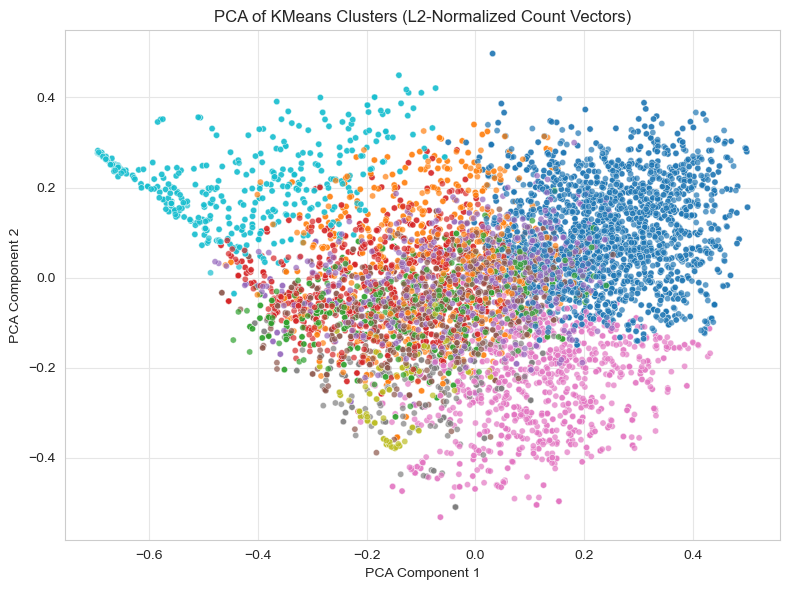

In [38]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(count_vectors_norm)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_l2_cluster,
                palette='tab10', s=20, ax=ax, alpha=0.7, legend=False)
ax.set_title('PCA of KMeans Clusters (L2-Normalized Count Vectors)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
plt.tight_layout()
plt.show()

## Perform Classification with Naive Bayes

### View the Distribution of Target Classes

In [39]:
# Is the dataset imbalanced?
print("Counts for each class:")
print(data_clean['Target'].value_counts())
print("\nProportions of each class:")
print(data_clean['Target'].value_counts() / len(data_clean['Target']) * 100)

Counts for each class:
Target
0    6954
1    2395
Name: count, dtype: int64

Proportions of each class:
Target
0    74.382287
1    25.617713
Name: count, dtype: float64


Spam makes up 26% of the data. 

### Reset the Indexes for Rows that were Dropped

In [40]:
# Align indexes
labels = data_clean["Target"].reset_index(drop=True)

# Sanity check
assert tfidf_kmeans.shape[0] == labels.shape[0]
assert tfidf_kmeans_l2.shape[0] == labels.shape[0]
assert tfidf_dbscan.shape[0] == labels.shape[0]

### Tuning of Naive Bayes Algorithm (Multinomial vs. Categorical) and Smoothing Parameter

#### On TF-IDF Features + DBSCAN Cluster

In [41]:
features = tfidf_dbscan  # or tfidf_kmeans 
labels = data_clean["Target"]
k = 5
alphas = np.arange(0.1, 1.1, 0.1)
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

# Discretize TF-IDF features for CategoricalNB
# For continuous TF_IDF features, they must be discretized before using CategoricalNB
# Apply global, fixed binning to all features
# features_discrete = features.copy()
# features_discrete.iloc[:, :-1] = features_discrete.iloc[:, :-1].apply(lambda x: pd.cut(x, bins=5, labels=False))
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
features_discrete = discretizer.fit_transform(features)
features_discrete = pd.DataFrame(
    features_discrete,
    columns=features.columns,
    index=features.index  # optional: keeps alignment if needed
)

results = {"MultinomialNB": [], "CategoricalNB": []}

for alpha in alphas:
    print(f"\n=== Alpha = {alpha:.3f} ===")
    
    for model_name, data in zip(["MultinomialNB", "CategoricalNB"], [features, features_discrete]):
        acc_scores, f1_scores, rec_scores, prec_scores = [], [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(data, labels), 1):
            X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
            y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]
            
            if model_name == "MultinomialNB":
                model = MultinomialNB(alpha=alpha)

            else:
                # Drop columns with only one unique value in the training set
                nunique = X_train.nunique()
                valid_cols = nunique[nunique > 1].index
                X_train = X_train[valid_cols]
                X_test = X_test[valid_cols]
                
                # Clip test bins to max seen in train per feature
                for col in valid_cols:
                    max_bin = X_train[col].max()
                    X_test[col] = X_test[col].clip(upper=max_bin)
                model = CategoricalNB(alpha=alpha)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            prec_scores.append(precision_score(y_test, y_pred, zero_division=0))
            rec_scores.append(recall_score(y_test, y_pred, zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        
        avg_result = {
            "alpha": alpha,
            "accuracy": np.mean(acc_scores),
            "precision": np.mean(prec_scores),
            "recall": np.mean(rec_scores),
            "f1": np.mean(f1_scores)
        }
        results[model_name].append(avg_result)
        
        print(f"{model_name} | Mean Accuracy: {avg_result['accuracy']:.4f}, "
              f"F1: {avg_result['f1']:.4f}, Recall: {avg_result['recall']:.4f}, "
              f"Precision: {avg_result['precision']:.4f}")



=== Alpha = 0.100 ===
MultinomialNB | Mean Accuracy: 0.9865, F1: 0.9732, Recall: 0.9557, Precision: 0.9914
CategoricalNB | Mean Accuracy: 0.9781, F1: 0.9555, Recall: 0.9194, Precision: 0.9946

=== Alpha = 0.200 ===
MultinomialNB | Mean Accuracy: 0.9739, F1: 0.9467, Recall: 0.9052, Precision: 0.9923
CategoricalNB | Mean Accuracy: 0.9649, F1: 0.9268, Recall: 0.8672, Precision: 0.9952

=== Alpha = 0.300 ===
MultinomialNB | Mean Accuracy: 0.9565, F1: 0.9075, Recall: 0.8347, Precision: 0.9945
CategoricalNB | Mean Accuracy: 0.9493, F1: 0.8904, Recall: 0.8042, Precision: 0.9974

=== Alpha = 0.400 ===
MultinomialNB | Mean Accuracy: 0.9405, F1: 0.8691, Recall: 0.7716, Precision: 0.9951
CategoricalNB | Mean Accuracy: 0.9289, F1: 0.8389, Recall: 0.7236, Precision: 0.9983

=== Alpha = 0.500 ===
MultinomialNB | Mean Accuracy: 0.9193, F1: 0.8137, Recall: 0.6885, Precision: 0.9952
CategoricalNB | Mean Accuracy: 0.9088, F1: 0.7832, Recall: 0.6447, Precision: 0.9987

=== Alpha = 0.600 ===
MultinomialN

#### On TF-IDF Features + K-Means Cluster (default Euclidean)

In [42]:
features = tfidf_kmeans
labels = data_clean["Target"]
k = 5
alphas = np.arange(0.1, 1.1, 0.1)
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

# Discretize TF-IDF features for CategoricalNB
# For continuous TF_IDF features, they must be discretized before using CategoricalNB
# Apply global, fixed binning to all features
# features_discrete = features.copy()
# features_discrete.iloc[:, :-1] = features_discrete.iloc[:, :-1].apply(lambda x: pd.cut(x, bins=5, labels=False))
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
features_discrete = discretizer.fit_transform(features)
features_discrete = pd.DataFrame(
    features_discrete,
    columns=features.columns,
    index=features.index  # optional: keeps alignment if needed
)

results = {"MultinomialNB": [], "CategoricalNB": []}

for alpha in alphas:
    print(f"\n=== Alpha = {alpha:.3f} ===")
    
    for model_name, data in zip(["MultinomialNB", "CategoricalNB"], [features, features_discrete]):
        acc_scores, f1_scores, rec_scores, prec_scores = [], [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(data, labels), 1):
            X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
            y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]
            
            # if model_name == "MultinomialNB":
            #     model = MultinomialNB(alpha=alpha)
            # else:
            #     model = CategoricalNB(alpha=alpha)
            if model_name == "MultinomialNB":
                model = MultinomialNB(alpha=alpha)

            else:
                # Drop columns with only one unique value in the training set
                nunique = X_train.nunique()
                valid_cols = nunique[nunique > 1].index
                X_train = X_train[valid_cols]
                X_test = X_test[valid_cols]
                
                # Clip test bins to max seen in train per feature
                for col in valid_cols:
                    max_bin = X_train[col].max()
                    X_test[col] = X_test[col].clip(upper=max_bin)
                model = CategoricalNB(alpha=alpha)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            prec_scores.append(precision_score(y_test, y_pred, zero_division=0))
            rec_scores.append(recall_score(y_test, y_pred, zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        
        avg_result = {
            "alpha": alpha,
            "accuracy": np.mean(acc_scores),
            "precision": np.mean(prec_scores),
            "recall": np.mean(rec_scores),
            "f1": np.mean(f1_scores)
        }
        results[model_name].append(avg_result)
        
        print(f"{model_name} | Mean Accuracy: {avg_result['accuracy']:.4f}, "
              f"F1: {avg_result['f1']:.4f}, Recall: {avg_result['recall']:.4f}, "
              f"Precision: {avg_result['precision']:.4f}")


=== Alpha = 0.100 ===
MultinomialNB | Mean Accuracy: 0.9855, F1: 0.9710, Recall: 0.9516, Precision: 0.9913
CategoricalNB | Mean Accuracy: 0.9776, F1: 0.9546, Recall: 0.9177, Precision: 0.9946

=== Alpha = 0.200 ===
MultinomialNB | Mean Accuracy: 0.9679, F1: 0.9337, Recall: 0.8814, Precision: 0.9925
CategoricalNB | Mean Accuracy: 0.9646, F1: 0.9261, Recall: 0.8660, Precision: 0.9952

=== Alpha = 0.300 ===
MultinomialNB | Mean Accuracy: 0.9553, F1: 0.9050, Recall: 0.8313, Precision: 0.9930
CategoricalNB | Mean Accuracy: 0.9490, F1: 0.8897, Recall: 0.8029, Precision: 0.9974

=== Alpha = 0.400 ===
MultinomialNB | Mean Accuracy: 0.9432, F1: 0.8759, Recall: 0.7829, Precision: 0.9942
CategoricalNB | Mean Accuracy: 0.9280, F1: 0.8366, Recall: 0.7203, Precision: 0.9983

=== Alpha = 0.500 ===
MultinomialNB | Mean Accuracy: 0.9306, F1: 0.8435, Recall: 0.7315, Precision: 0.9966
CategoricalNB | Mean Accuracy: 0.9089, F1: 0.7835, Recall: 0.6451, Precision: 0.9987

=== Alpha = 0.600 ===
MultinomialN

#### On TF-IDF Features + K-Means Cluster after L2 Normalization

In [43]:
features = tfidf_kmeans_l2
labels = data_clean["Target"]
k = 5
alphas = np.concatenate([
    np.array([0.01, 0.05, 0.1]),
    np.arange(0.2, 0.6, 0.1)
])
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

# Discretize TF-IDF features for CategoricalNB
# For continuous TF_IDF features, they must be discretized before using CategoricalNB
# Apply global, fixed binning to all features
# features_discrete = features.copy()
# features_discrete.iloc[:, :-1] = features_discrete.iloc[:, :-1].apply(lambda x: pd.cut(x, bins=5, labels=False))
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
features_discrete = discretizer.fit_transform(features)
features_discrete = pd.DataFrame(
    features_discrete,
    columns=features.columns,
    index=features.index  # optional: keeps alignment if needed
)

results = {"MultinomialNB": [], "CategoricalNB": []}

for alpha in alphas:
    print(f"\n=== Alpha = {alpha:.3f} ===")
    
    for model_name, data in zip(["MultinomialNB", "CategoricalNB"], [features, features_discrete]):
        acc_scores, f1_scores, rec_scores, prec_scores = [], [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(data, labels), 1):
            X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
            y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]
            
            # if model_name == "MultinomialNB":
            #     model = MultinomialNB(alpha=alpha)
            # else:
            #     model = CategoricalNB(alpha=alpha)
            if model_name == "MultinomialNB":
                model = MultinomialNB(alpha=alpha)

            else:
                # Drop columns with only one unique value in the training set
                nunique = X_train.nunique()
                valid_cols = nunique[nunique > 1].index
                X_train = X_train[valid_cols]
                X_test = X_test[valid_cols]
                
                # Clip test bins to max seen in train per feature
                for col in valid_cols:
                    max_bin = X_train[col].max()
                    X_test[col] = X_test[col].clip(upper=max_bin)
                model = CategoricalNB(alpha=alpha)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            prec_scores.append(precision_score(y_test, y_pred, zero_division=0))
            rec_scores.append(recall_score(y_test, y_pred, zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        
        avg_result = {
            "alpha": alpha,
            "accuracy": np.mean(acc_scores),
            "precision": np.mean(prec_scores),
            "recall": np.mean(rec_scores),
            "f1": np.mean(f1_scores)
        }
        results[model_name].append(avg_result)
        
        print(f"{model_name} | Mean Accuracy: {avg_result['accuracy']:.4f}, "
              f"F1: {avg_result['f1']:.4f}, Recall: {avg_result['recall']:.4f}, "
              f"Precision: {avg_result['precision']:.4f}")


=== Alpha = 0.010 ===
MultinomialNB | Mean Accuracy: 0.9919, F1: 0.9840, Recall: 0.9762, Precision: 0.9920
CategoricalNB | Mean Accuracy: 0.9825, F1: 0.9647, Recall: 0.9353, Precision: 0.9960

=== Alpha = 0.050 ===
MultinomialNB | Mean Accuracy: 0.9898, F1: 0.9799, Recall: 0.9695, Precision: 0.9906
CategoricalNB | Mean Accuracy: 0.9826, F1: 0.9649, Recall: 0.9361, Precision: 0.9956

=== Alpha = 0.100 ===
MultinomialNB | Mean Accuracy: 0.9872, F1: 0.9745, Recall: 0.9582, Precision: 0.9914
CategoricalNB | Mean Accuracy: 0.9778, F1: 0.9548, Recall: 0.9186, Precision: 0.9941

=== Alpha = 0.200 ===
MultinomialNB | Mean Accuracy: 0.9757, F1: 0.9506, Recall: 0.9127, Precision: 0.9919
CategoricalNB | Mean Accuracy: 0.9649, F1: 0.9268, Recall: 0.8672, Precision: 0.9952

=== Alpha = 0.300 ===
MultinomialNB | Mean Accuracy: 0.9586, F1: 0.9125, Recall: 0.8434, Precision: 0.9941
CategoricalNB | Mean Accuracy: 0.9510, F1: 0.8945, Recall: 0.8104, Precision: 0.9979

=== Alpha = 0.400 ===
MultinomialN

In [44]:
print(type(tfidf_kmeans_l2))
print(tfidf_kmeans_l2.shape)
print(tfidf_df.shape)

<class 'pandas.core.frame.DataFrame'>
(9349, 88902)
(9349, 88901)


#### Compare Classification Results on Only TF-IDF Features (no Clusters) to those with Clusters

In [45]:
features = tfidf_df
labels = data_clean["Target"]
k = 5
alphas = np.array([0.01, 0.05, 0.1, 0.2])
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

# Discretize TF-IDF features for CategoricalNB
# For continuous TF_IDF features, they must be discretized before using CategoricalNB
# Apply global, fixed binning to all features
# features_discrete = features.copy()
# features_discrete.iloc[:, :-1] = features_discrete.iloc[:, :-1].apply(lambda x: pd.cut(x, bins=5, labels=False))
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
features_discrete = discretizer.fit_transform(features)
features_discrete = pd.DataFrame(
    features_discrete,
    columns=features.columns,
    index=features.index  # optional: keeps alignment if needed
)

results = {"MultinomialNB": [], "CategoricalNB": []}

for alpha in alphas:
    print(f"\n=== Alpha = {alpha:.3f} ===")
    
    for model_name, data in zip(["MultinomialNB", "CategoricalNB"], [features, features_discrete]):
        acc_scores, f1_scores, rec_scores, prec_scores = [], [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(data, labels), 1):
            X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
            y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]
            
            # if model_name == "MultinomialNB":
            #     model = MultinomialNB(alpha=alpha)
            # else:
            #     model = CategoricalNB(alpha=alpha)
            if model_name == "MultinomialNB":
                model = MultinomialNB(alpha=alpha)

            else:
                # Drop columns with only one unique value in the training set
                nunique = X_train.nunique()
                valid_cols = nunique[nunique > 1].index
                X_train = X_train[valid_cols]
                X_test = X_test[valid_cols]
                
                # Clip test bins to max seen in train per feature
                for col in valid_cols:
                    max_bin = X_train[col].max()
                    X_test[col] = X_test[col].clip(upper=max_bin)
                model = CategoricalNB(alpha=alpha)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            prec_scores.append(precision_score(y_test, y_pred, zero_division=0))
            rec_scores.append(recall_score(y_test, y_pred, zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        
        avg_result = {
            "alpha": alpha,
            "accuracy": np.mean(acc_scores),
            "precision": np.mean(prec_scores),
            "recall": np.mean(rec_scores),
            "f1": np.mean(f1_scores)
        }
        results[model_name].append(avg_result)
        
        print(f"{model_name} | Mean Accuracy: {avg_result['accuracy']:.4f}, "
              f"F1: {avg_result['f1']:.4f}, Recall: {avg_result['recall']:.4f}, "
              f"Precision: {avg_result['precision']:.4f}")


=== Alpha = 0.010 ===
MultinomialNB | Mean Accuracy: 0.9911, F1: 0.9825, Recall: 0.9724, Precision: 0.9928
CategoricalNB | Mean Accuracy: 0.9824, F1: 0.9645, Recall: 0.9349, Precision: 0.9960

=== Alpha = 0.050 ===
MultinomialNB | Mean Accuracy: 0.9899, F1: 0.9802, Recall: 0.9708, Precision: 0.9898
CategoricalNB | Mean Accuracy: 0.9814, F1: 0.9625, Recall: 0.9315, Precision: 0.9955

=== Alpha = 0.100 ===
MultinomialNB | Mean Accuracy: 0.9866, F1: 0.9734, Recall: 0.9570, Precision: 0.9905
CategoricalNB | Mean Accuracy: 0.9778, F1: 0.9548, Recall: 0.9182, Precision: 0.9946

=== Alpha = 0.200 ===
MultinomialNB | Mean Accuracy: 0.9757, F1: 0.9506, Recall: 0.9123, Precision: 0.9923
CategoricalNB | Mean Accuracy: 0.9646, F1: 0.9261, Recall: 0.8660, Precision: 0.9952


### Fit the Final NB Model and Get Predictions and Metrics

#### Basic Classification Report

In [46]:
# Instantiate the final model with the tuned smoothing parameter, alpha
final_model = MultinomialNB(alpha=0.01)

# Instantiate the cross validatation object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Define X and y
features = tfidf_kmeans_l2
labels = data_clean["Target"]

# Get cross-validated predictions
y_preds = cross_val_predict(final_model, features, labels, cv=cv)

# Evaluate
print(classification_report(labels, y_preds))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6954
           1       0.99      0.98      0.98      2395

    accuracy                           0.99      9349
   macro avg       0.99      0.99      0.99      9349
weighted avg       0.99      0.99      0.99      9349



#### Detailed Classification Report

In [48]:
# Initialize model and CV
final_model = MultinomialNB(alpha=0.01)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

features = tfidf_kmeans_l2
labels = data_clean["Target"]

# Metric storage
accs, bal_accs = [], []
precs_0, recs_0, f1s_0 = [], [], []
precs_1, recs_1, f1s_1 = [], [], []
precs_w, recs_w, f1s_w = [], [], []
aucs = []

for train_idx, test_idx in cv.split(features, labels):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]

    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)
    y_probs = final_model.predict_proba(X_test)[:, 1]

    # Accuracy and Balanced Accuracy
    accs.append(accuracy_score(y_test, y_pred))
    bal_accs.append(balanced_accuracy_score(y_test, y_pred))

    # Class 0 metrics
    precs_0.append(precision_score(y_test, y_pred, pos_label=0))
    recs_0.append(recall_score(y_test, y_pred, pos_label=0))
    f1s_0.append(f1_score(y_test, y_pred, pos_label=0))

    # Class 1 metrics
    precs_1.append(precision_score(y_test, y_pred, pos_label=1))
    recs_1.append(recall_score(y_test, y_pred, pos_label=1))
    f1s_1.append(f1_score(y_test, y_pred, pos_label=1))

    # Weighted metrics
    precs_w.append(precision_score(y_test, y_pred, average='weighted'))
    recs_w.append(recall_score(y_test, y_pred, average='weighted'))
    f1s_w.append(f1_score(y_test, y_pred, average='weighted'))

    # AUC
    aucs.append(roc_auc_score(y_test, y_probs))

# Create and display summary table
metrics_df = pd.DataFrame({
    "Accuracy": [f"{np.mean(accs):.4f} ± {np.std(accs):.4f}"],
    "Balanced Accuracy": [f"{np.mean(bal_accs):.4f} ± {np.std(bal_accs):.4f}"],
    "Precision (0)": [f"{np.mean(precs_0):.4f} ± {np.std(precs_0):.4f}"],
    "Recall (0)": [f"{np.mean(recs_0):.4f} ± {np.std(recs_0):.4f}"],
    "F1 (0)": [f"{np.mean(f1s_0):.4f} ± {np.std(f1s_0):.4f}"],
    "Precision (1)": [f"{np.mean(precs_1):.4f} ± {np.std(precs_1):.4f}"],
    "Recall (1)": [f"{np.mean(recs_1):.4f} ± {np.std(recs_1):.4f}"],
    "F1 (1)": [f"{np.mean(f1s_1):.4f} ± {np.std(f1s_1):.4f}"],
    "Weighted Precision": [f"{np.mean(precs_w):.4f} ± {np.std(precs_w):.4f}"],
    "Weighted Recall": [f"{np.mean(recs_w):.4f} ± {np.std(recs_w):.4f}"],
    "Weighted F1": [f"{np.mean(f1s_w):.4f} ± {np.std(f1s_w):.4f}"],
    "ROC AUC": [f"{np.mean(aucs):.4f} ± {np.std(aucs):.4f}"]
})

print(metrics_df)

          Accuracy Balanced Accuracy    Precision (0)       Recall (0)  \
0  0.9919 ± 0.0024   0.9867 ± 0.0040  0.9919 ± 0.0026  0.9973 ± 0.0015   

            F1 (0)    Precision (1)       Recall (1)           F1 (1)  \
0  0.9946 ± 0.0016  0.9920 ± 0.0043  0.9762 ± 0.0075  0.9840 ± 0.0047   

  Weighted Precision  Weighted Recall      Weighted F1          ROC AUC  
0    0.9919 ± 0.0024  0.9919 ± 0.0024  0.9918 ± 0.0024  0.9996 ± 0.0002  


In [49]:
# Get feature names and log-probabilities
feature_names = tfidf_kmeans_l2.columns
log_probs = final_model.feature_log_prob_  # shape (n_classes, n_features)

# Build DataFrame for both classes
feature_df = pd.DataFrame({
    'feature': feature_names,
    'log_prob_spam': log_probs[1],
    'log_prob_ham': log_probs[0],
})

# Compute difference in log-probs for discriminative power
feature_df['log_prob_ratio'] = feature_df['log_prob_spam'] - feature_df['log_prob_ham']
feature_df['abs_ratio'] = feature_df['log_prob_ratio'].abs()

# Top 20 for each class and for discriminative features
top_spam = feature_df.sort_values('log_prob_spam', ascending=False).head(20)
top_ham = feature_df.sort_values('log_prob_ham', ascending=False).head(20)
top_discriminative = feature_df.sort_values('abs_ratio', ascending=False).head(20)

# Display results
print("\nTop 20 features most indicative of spam (class 1):")
for _, row in top_spam.iterrows():
    print(f"{row['feature']}: log P(feature|spam) = {row['log_prob_spam']:.4f}")

print("\nTop 20 features most indicative of not spam (class 0):")
for _, row in top_ham.iterrows():
    print(f"{row['feature']}: log P(feature|ham) = {row['log_prob_ham']:.4f}")

print("\nTop 20 most discriminative features (log P(spam) - log P(ham)):")
for _, row in top_discriminative.iterrows():
    sign = "spam" if row["log_prob_ratio"] > 0 else "ham"
    print(f"{row['feature']}: {row['log_prob_ratio']:.4f} ({sign})")


Top 20 features most indicative of spam (class 1):
KMeans_Cluster_Norm: log P(feature|spam) = -1.1426
to: log P(feature|spam) = -5.0886
you: log P(feature|spam) = -5.1103
the: log P(feature|spam) = -5.2536
your: log P(feature|spam) = -5.3604
and: log P(feature|spam) = -5.4305
of: log P(feature|spam) = -5.6820
for: log P(feature|spam) = -5.7899
this: log P(feature|spam) = -5.8539
our: log P(feature|spam) = -5.8789
in: log P(feature|spam) = -5.9144
we: log P(feature|spam) = -5.9434
click: log P(feature|spam) = -5.9822
free: log P(feature|spam) = -6.0444
here: log P(feature|spam) = -6.0580
is: log P(feature|spam) = -6.2054
email: log P(feature|spam) = -6.2089
or: log P(feature|spam) = -6.2358
be: log P(feature|spam) = -6.2466
are: log P(feature|spam) = -6.2807

Top 20 features most indicative of not spam (class 0):
KMeans_Cluster_Norm: log P(feature|ham) = -1.4200
the: log P(feature|ham) = -4.7732
to: log P(feature|ham) = -5.1929
of: log P(feature|ham) = -5.4928
and: log P(feature|ham) =

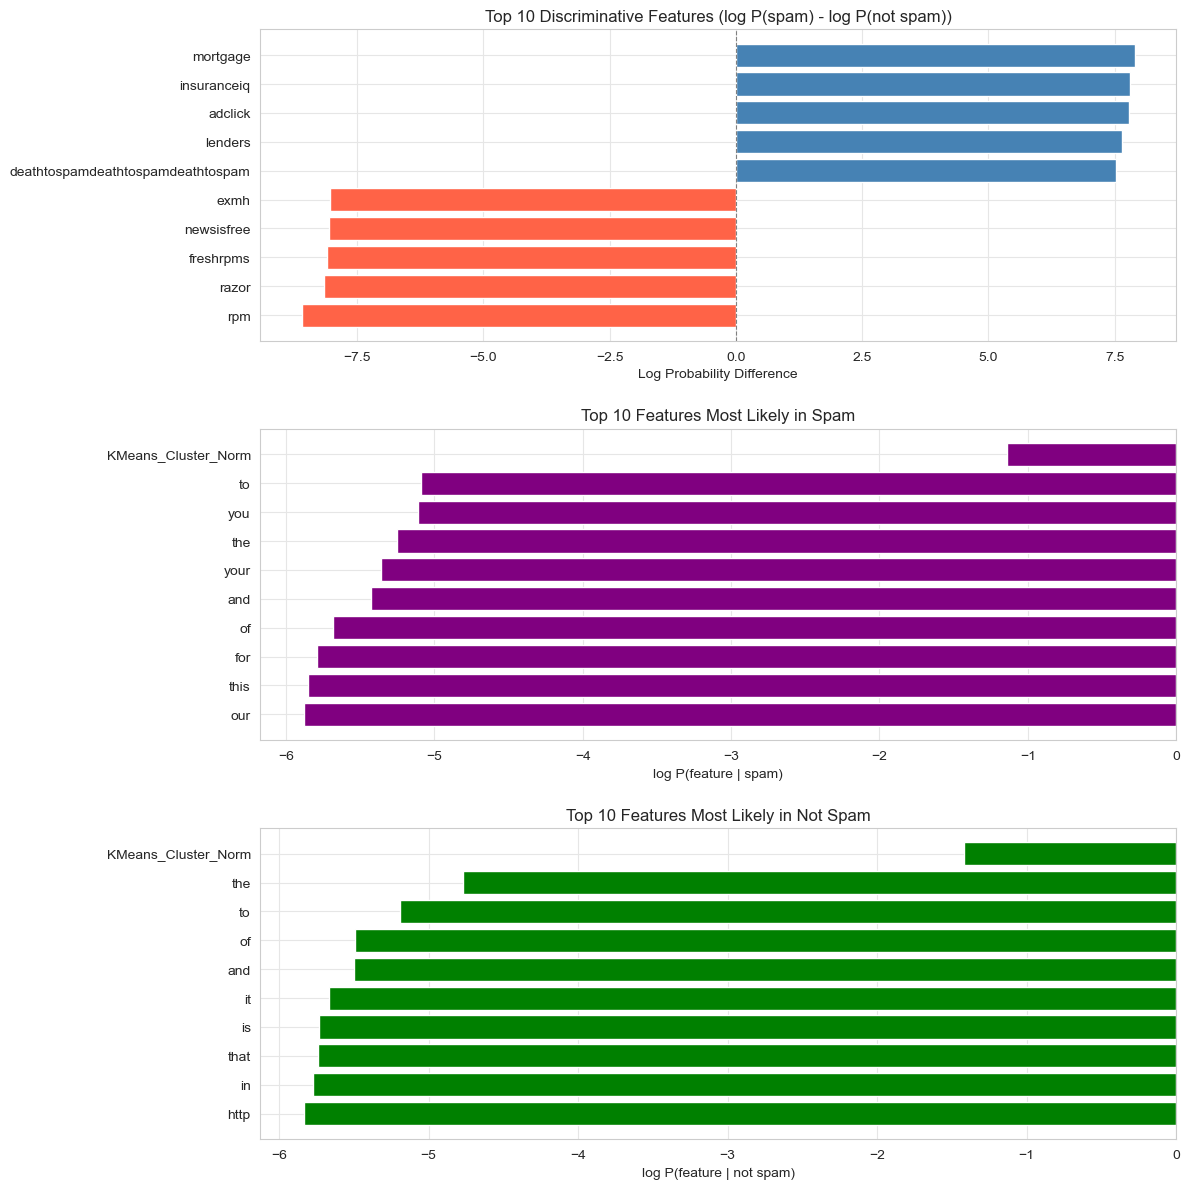

In [50]:
# Step 1: Build DataFrame with log-probabilities
feature_names = tfidf_kmeans_l2.columns
log_probs = final_model.feature_log_prob_

coef_df = pd.DataFrame({
    'feature': feature_names,
    'log_P(spam)': log_probs[1],
    'log_P(ham)': log_probs[0],
    'log_diff': log_probs[1] - log_probs[0],
    'abs_log_diff': np.abs(log_probs[1] - log_probs[0]),
    'P(spam)': np.exp(log_probs[1]),
    'P(ham)': np.exp(log_probs[0])
}).set_index('feature')

# Step 2: Select Top Features (fix sorting)
top_discriminative = coef_df.sort_values('abs_log_diff', ascending=False).head(10)
top_spam = coef_df.sort_values('log_P(spam)', ascending=False).head(10)
top_ham = coef_df.sort_values('log_P(ham)', ascending=False).head(10)

# Step 3: Create 3-in-1 subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=False)

# --- Plot 1: Discriminative Features ---
sorted_disc = top_discriminative['log_diff'].sort_values()
colors = ['steelblue' if val > 0 else 'tomato' for val in sorted_disc]
axes[0].barh(sorted_disc.index, sorted_disc.values, color=colors)
axes[0].axvline(0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_title("Top 10 Discriminative Features (log P(spam) - log P(not spam))")
axes[0].set_xlabel("Log Probability Difference")

# --- Plot 2: Top Spam Features ---
sorted_spam = top_spam['log_P(spam)'].sort_values()
axes[1].barh(sorted_spam.index, sorted_spam.values, color='purple')
axes[1].set_title("Top 10 Features Most Likely in Spam")
axes[1].set_xlabel("log P(feature | spam)")

# --- Plot 3: Top Ham Features ---
sorted_ham = top_ham['log_P(ham)'].sort_values()
axes[2].barh(sorted_ham.index, sorted_ham.values, color='green')
axes[2].set_title("Top 10 Features Most Likely in Not Spam")
axes[2].set_xlabel("log P(feature | not spam)")

plt.tight_layout(h_pad=2)
plt.show()

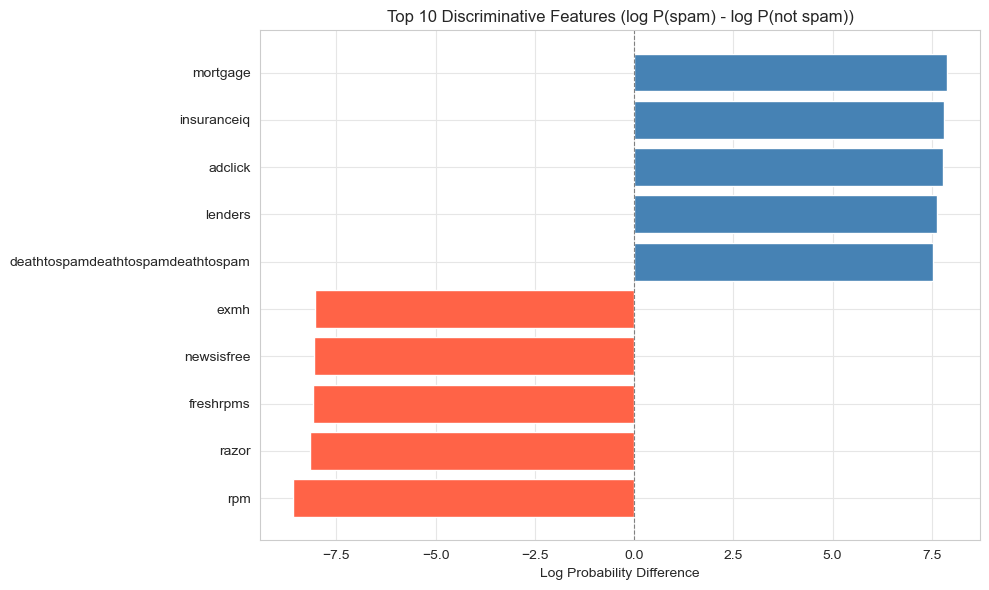

In [51]:
# Just the discriminative features
# Sort by log probability difference (spam - not spam)
sorted_disc = top_discriminative['log_diff'].sort_values()
colors = ['steelblue' if val > 0 else 'tomato' for val in sorted_disc]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(sorted_disc.index, sorted_disc.values, color=colors)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_title("Top 10 Discriminative Features (log P(spam) - log P(not spam))")
ax.set_xlabel("Log Probability Difference")
plt.tight_layout()
plt.show()

### Plot a Confusion Matrix

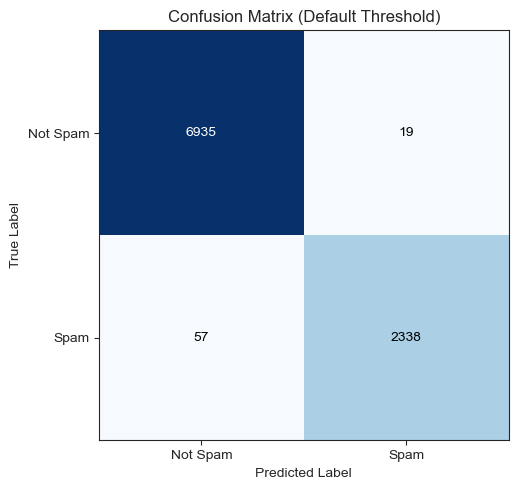

In [52]:
# Confusion Matrix
cm = confusion_matrix(labels, y_preds)
# class_order = final_model.classes_  # This should be [0, 1] = ['Not Spam', 'Spam']
class_order = ['Not Spam', 'Spam']

sns.set_style('ticks')

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')
ax.set_title('Confusion Matrix (Default Threshold)')
ax.set_xticks(np.arange(len(class_order)))
ax.set_yticks(np.arange(len(class_order)))
ax.set_xticklabels(class_order)
ax.set_yticklabels(class_order)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Normalize for adaptive text color
norm = plt.Normalize(cm.min(), cm.max())
colors = plt.cm.Blues(norm(cm))

# Annotate cells
for i in range(len(class_order)):
    for j in range(len(class_order)):
        val = cm[i, j]
        bg_color = colors[i, j]
        brightness = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
        text_color = 'white' if brightness < 0.5 else 'black'
        ax.text(j, i, val, ha='center', va='center', color=text_color)

plt.tight_layout()
plt.show()

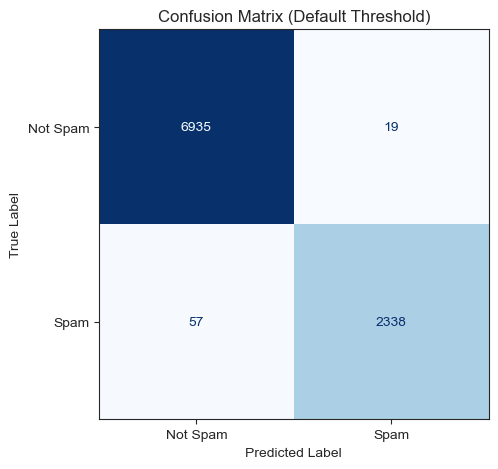

In [53]:
# Very simple way to make a confusion matrix plot
# Class labels for ticks (e.g., 0 = Not Spam, 1 = Spam)
class_order = ['Not Spam', 'Spam']

# Set Seaborn style
sns.set_style('ticks')

# Create and customize the plot
disp = ConfusionMatrixDisplay.from_predictions(labels, y_preds, cmap='Blues', colorbar=False)

# Now set tick labels on the returned axis
disp.ax_.set_xticklabels(class_order)
disp.ax_.set_yticklabels(class_order)
disp.ax_.set_xlabel("Predicted Label")
disp.ax_.set_ylabel("True Label")
disp.ax_.set_title("Confusion Matrix (Default Threshold)")

plt.tight_layout()
plt.show()

### Plot the ROC Curve

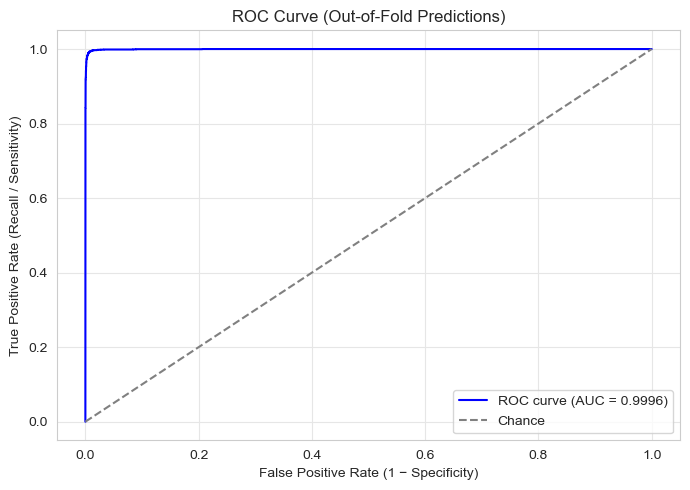

In [54]:
# Get predicted probabilities
y_probs = cross_val_predict(final_model, features, labels, cv=cv, method='predict_proba')

# Extract probabilities for the positive class (Spam = 1)
y_score = y_probs[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, y_score)
roc_auc = auc(fpr, tpr)

# Set a cleaner seaborn style with lighter grid
sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.9'})

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Recall / Sensitivity)")
plt.title("ROC Curve (Out-of-Fold Predictions)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Compare Results after One-Hot-Encoding Clusters to Remove Ordinal Info

In [55]:
# One Hot Encode Cluster Feature (to remove ordinal info)
encoder = OneHotEncoder(sparse_output=False)
clusters_ohe = encoder.fit_transform(kmeans_l2_cluster.values.reshape(-1, 1))

# Make sure cluster columns have string names
cluster_columns = [f"cluster_{i}" for i in range(clusters_ohe.shape[1])]
clusters_df = pd.DataFrame(clusters_ohe, columns=cluster_columns)

# Concatenate with tf-idf features
tfidf_kmeans_l2_one = pd.concat([tfidf_df, clusters_df], axis=1)

features = tfidf_kmeans_l2_one
labels = data_clean["Target"]
k = 5
alphas = np.array([0.01, 0.05, 0.1])
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

results = {"MultinomialNB": []}

for alpha in alphas:
    print(f"\n=== Alpha = {alpha:.3f} ===")
    
    for model_name, data in zip(["MultinomialNB"], [features]):
        acc_scores, f1_scores, rec_scores, prec_scores = [], [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(data, labels), 1):
            X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
            y_train, y_test = labels.iloc[train_idx], labels.iloc[test_idx]
            
            model = MultinomialNB(alpha=alpha)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc_scores.append(accuracy_score(y_test, y_pred))
            prec_scores.append(precision_score(y_test, y_pred, zero_division=0))
            rec_scores.append(recall_score(y_test, y_pred, zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        
        avg_result = {
            "alpha": alpha,
            "accuracy": np.mean(acc_scores),
            "precision": np.mean(prec_scores),
            "recall": np.mean(rec_scores),
            "f1": np.mean(f1_scores)
        }
        results[model_name].append(avg_result)
        
        print(f"{model_name} | Mean Accuracy: {avg_result['accuracy']:.4f}, "
              f"F1: {avg_result['f1']:.4f}, Recall: {avg_result['recall']:.4f}, "
              f"Precision: {avg_result['precision']:.4f}")


=== Alpha = 0.010 ===
MultinomialNB | Mean Accuracy: 0.9907, F1: 0.9817, Recall: 0.9749, Precision: 0.9886

=== Alpha = 0.050 ===
MultinomialNB | Mean Accuracy: 0.9873, F1: 0.9749, Recall: 0.9666, Precision: 0.9835

=== Alpha = 0.100 ===
MultinomialNB | Mean Accuracy: 0.9841, F1: 0.9683, Recall: 0.9524, Precision: 0.9849


I also tested one-hot encoding the KMeans cluster feature to remove any implied ordinal structure and give the model more flexibility in modeling class-conditional probabilities by cluster. The performance change was negligible, likely due to strong signal already captured by TF-IDF. I retained the single cluster ID as a simpler and equally effective feature.